In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.0.1+cu118


In [3]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.0 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-w45jvbzt
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-w45jvbzt
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=5baafee7c44ce7ec97b7dd9bb1e27456f8279f2a3171157274f9ed45a0b0cdd4
  Stored in directory: /tmp/pip-ephem-wheel-cache-qur9a_yx/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
import os
import torchvision.models as models

In [5]:
import torchvision
import torchvision.transforms as transforms
import os
from torch.utils.data import random_split
import torch
import clip
from PIL import Image
from torch.utils.data import Dataset

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [27]:
model, preprocess = clip.load("ViT-L/14")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

100%|███████████████████████████████████████| 890M/890M [00:28<00:00, 32.4MiB/s]


In [28]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from torch.utils.data import DataLoader

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-L/14', device)

# Define the root path to the train and test folders
root_folder = '/content/drive/MyDrive/korea_influencer/'

# Define subfolder paths
train_folder = os.path.join(root_folder, 'KI_tiny_50')
test_folder = os.path.join(root_folder, 'test')

train = torchvision.datasets.ImageFolder(root=train_folder, transform=preprocess)
test = torchvision.datasets.ImageFolder(root=test_folder, transform=preprocess)

def get_features(dataset):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# Calculate the image features
train_features, train_labels = get_features(train)
test_features, test_labels = get_features(test)

# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(train_features, train_labels)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

100%|██████████| 50/50 [01:42<00:00,  2.05s/it]


Accuracy = 88.400


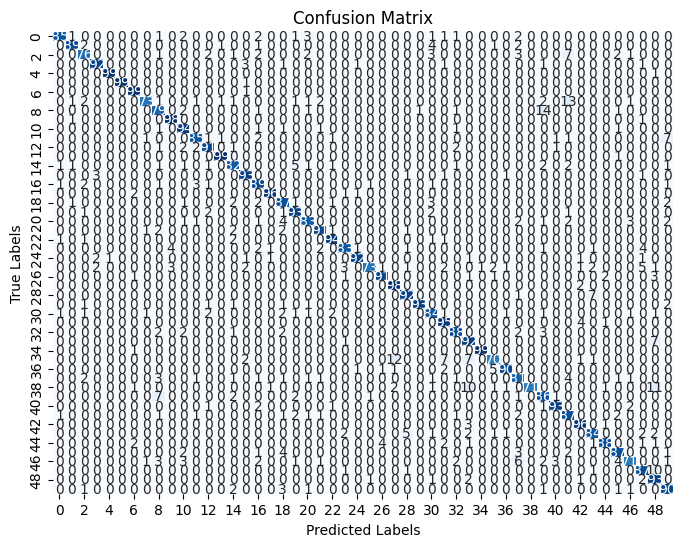

              precision    recall  f1-score   support

        0000       0.94      0.85      0.89       100
        0001       0.95      0.89      0.92       100
        0002       0.85      0.76      0.80       100
        0003       0.93      0.92      0.92       100
        0004       0.99      0.99      0.99       100
        0005       1.00      0.99      0.99       100
        0006       0.93      0.99      0.96       100
        0007       0.95      0.73      0.82       100
        0008       0.76      0.79      0.77       100
        0009       0.93      0.98      0.96       100
        0010       0.85      0.94      0.90       100
        0011       0.90      0.85      0.88       100
        0012       0.89      0.91      0.90       100
        0013       0.97      0.99      0.98       100
        0014       0.84      0.82      0.83       100
        0015       0.90      0.93      0.92       100
        0016       0.82      0.89      0.85       100
        0017       0.97    

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot a confusion matrix
cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# You can also plot other evaluation metrics like precision, recall, and F1-score
from sklearn.metrics import classification_report

report = classification_report(test_labels, predictions, target_names=train.classes)
print(report)